REDES NEURONALES CONVOLUCIONALES

---

Vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajas de manera local tendrás que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training y test puede ser descargado desde aquí:

[DATASET](https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset?resource=download) (~1 GB)


# Carga de los datos

In [1]:
# Librerías a utilizar
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import zipfile
import seaborn as sb
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation , Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from keras.optimizers import Adam, SGD
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, cohen_kappa_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
# Tamaño para imagenes
plt.rcParams["figure.figsize"] = (20,6)

C:\Users\i9_MGC\anaconda3\envs\tensor-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Carpeta de datos 
DATASET_TRAIN_DIR = '/Users/i9_MGC/Documents/Aprendizaje/Maestria/ASIGNATURAS TERCER SEMESTRE/Sistemas Cognitivos Artificiales (MEXINART) - Noviembre 2025 3Q/ACT2/mexmiart05_act2_grupal/simpsons_data/simpsons_dataset_train'
DATASET_TEST_DIR = '/Users/i9_MGC/Documents/Aprendizaje/Maestria/ASIGNATURAS TERCER SEMESTRE/Sistemas Cognitivos Artificiales (MEXINART) - Noviembre 2025 3Q/ACT2/mexmiart05_act2_grupal/simpsons_data/simpsons_dataset_test'

# Verificar existencia de directorios
assert os.path.exists(DATASET_TRAIN_DIR), f"❌ No se encuentra: {DATASET_TRAIN_DIR}"
assert os.path.exists(DATASET_TEST_DIR), f"❌ No se encuentra: {DATASET_TEST_DIR}"
print("✅ Directorios de datos verificados")

✅ Directorios de datos verificados


In [3]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [4]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []

    for label, character in map_characters.items():        
        path_character = os.path.join(dirname, character)
        if not os.path.exists(path_character):
            continue

        files = os.listdir(path_character)
        images = [file for file in files if file.lower().endswith(("jpg", "png", "jpeg"))]
        
        if verbose:
            print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
            
        for image_name in images:
            image_path = os.path.join(dirname, character, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                X_train.append(image)
                y_train.append(label)
                
    return np.array(X_train), np.array(y_train)

In [5]:
def load_test_set(dirname, map_characters, verbose=True):
    """
    Carga datos de test desde una carpeta plana, infiriendo la etiqueta
    del nombre del archivo.
    """
    X_test = []
    y_test = []
    
    if not os.path.exists(dirname):
        print(f"❌ ERROR: No existe la ruta de test: {dirname}")
        return np.array(X_test), np.array(y_test)
        
    # Invertimos el mapa para buscar por nombre: {'homer_simpson': 7, ...}
    reverse_dict = {v: k for k, v in map_characters.items()}
    
    # Leemos todos los archivos de la carpeta
    files = os.listdir(dirname)
    
    for filename in files:
        # Solo procesamos imágenes
        if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
            
        # Lógica robusta: Buscamos qué nombre de personaje está DENTRO del nombre de archivo
        # Ej: Si archivo es "bart_simpson_15.jpg", encuentra "bart_simpson"
        for char_name, label_id in reverse_dict.items():
            if char_name in filename:
                image_path = os.path.join(dirname, filename)
                image = cv2.imread(image_path)
                
                if image is not None:
                    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                    X_test.append(image)
                    y_test.append(label_id)
                break # Ya encontramos el personaje, pasamos a la siguiente imagen

    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
        
    return np.array(X_test), np.array(y_test)

In [6]:
# --- EJECUCIÓN ---
print("Cargando datos...")
# Cargamos los datos
X, y = load_train_set(DATASET_TRAIN_DIR, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_DIR, MAP_CHARACTERS)

print(f"\nResumen final:")
print(f"Train shape: {X.shape}")
print(f"Test shape: {X_t.shape}")

Cargando datos...
Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test

Resumen

In [7]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

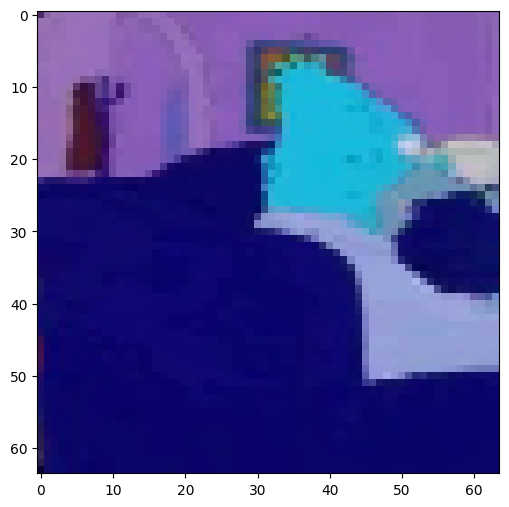

In [8]:
plt.imshow(X_t[2])

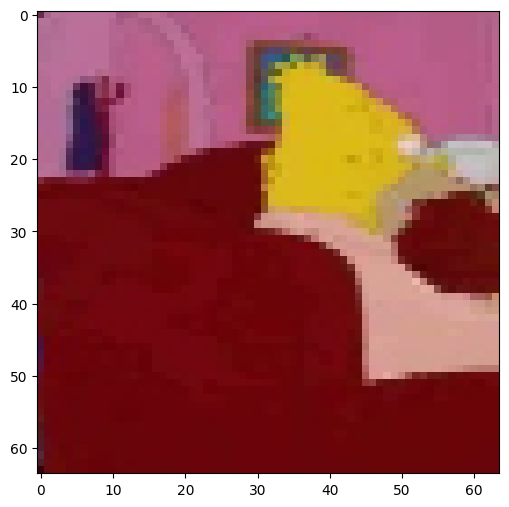

In [9]:
plt.imshow(np.flip(X_t[2], axis=-1) ) 

# Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en vuestro informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

# Análisis de datos a utilizar

+ El conjunto de datos se compone de imágenes a color con 3 canales (RGB) y una resolución uniforme de 64x64 píxeles. Los datos se dividen de la siguiente manera:

Set de Entrenamiento: 18,992 imágenes.
Set de Prueba: 890 imágenes.

* Originalmente, la intensidad de los píxeles se distribuye en un rango entero de 0 (negro) a 255 (blanco). Para optimizar el procesamiento computacional, se aplicará una normalización a los datos: al dividir cada valor entre 255, reescalamos las entradas al intervalo unitario $[0, 1]$, lo cual mejora la estabilidad numérica del análisis.

* Para preparar los datos de salida, aplicaremos una codificación One-Hot a las etiquetas. Convertiremos cada categoría numérica en un vector binario de 18 dimensiones.

La estructura funciona de la siguiente manera:

Se asigna un valor de 1 en la posición del índice correspondiente a la clase activa (ej. índice 2 para Bart Simpson).

Se asignan valores de 0 en todas las posiciones restantes.

El resultado es un vector disperso, por ejemplo: [0, 0, 1, 0, ..., 0]. Esta transformación es indispensable para realizar una clasificación multiclase, permitiendo que cada posición del vector se corresponda con la probabilidad de una neurona específica en la capa de salida con activación Softmax.

Después se mostraran unas imágenes del dataset para una entender de mejor manera el análisis de datos.


In [10]:
print("Estructura del dataset de entrenamiento para CNN: " +str(X.shape))
print("Estructura del dataset de prueba para CNN: " +str(X_t.shape))

# Normalizacion de datos
X = X / 255.0
X_t = X_t / 255.0

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
labels=y;
labels_test=y_t;
y = keras.utils.to_categorical(y, num_classes = 18)
y_t = keras.utils.to_categorical(y_t, num_classes = 18)

Estructura del dataset de entrenamiento para CNN: (18992, 64, 64, 3)
Estructura del dataset de prueba para CNN: (890, 64, 64, 3)


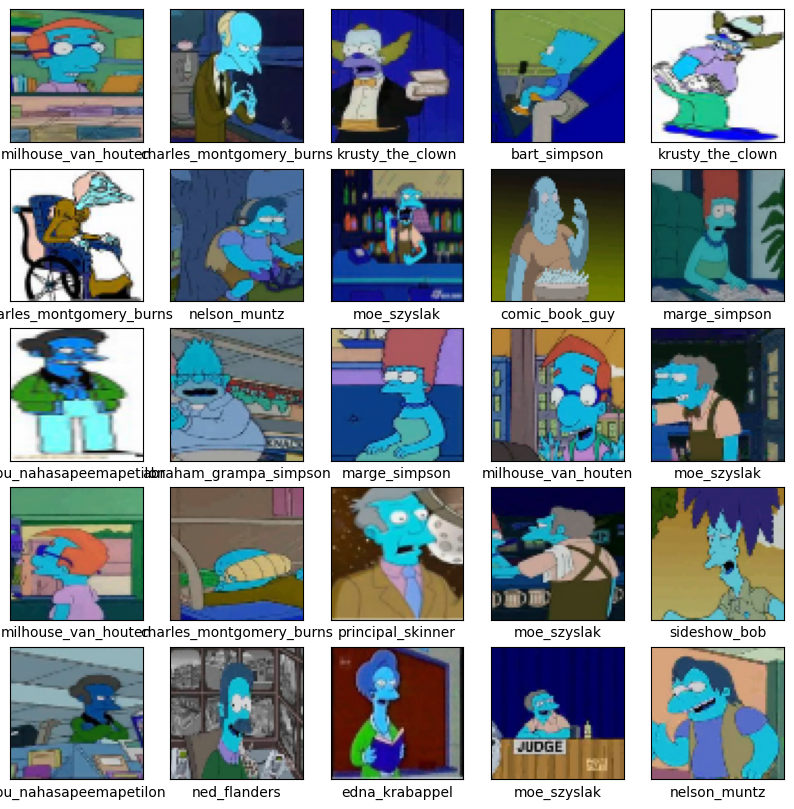

In [11]:
class_names = ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson',
     'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel',
     'homer_simpson',  'kent_brockman',  'krusty_the_clown',  'lisa_simpson',
     'marge_simpson', 'milhouse_van_houten',  'moe_szyslak',
    'ned_flanders',  'nelson_muntz', 'principal_skinner',  'sideshow_bob']

# Mostramos algunas imágenes
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    #Elegir índice aleatorio (para que salgan variados)
    idx = np.random.randint(0, len(X_t))
    
    #Mostrar imagen
    plt.imshow(X_t[idx], cmap=plt.cm.binary) 
    true_label_index = np.argmax(y_t[idx])
    plt.xlabel(class_names[true_label_index]) 

plt.show()

* Definimos posteriomente algunas funciones para realizar gráficas de distintos indicadores de presición del modelo.

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusión',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y plotea la matriz de confusión.
    La normalización se puede aplicar estableciendo `normalize=True`.
    """
    plt.figure(figsize=(12, 12)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta Real (Original)')
    plt.xlabel('Etiqueta Predicha')

def plot_acc(history, title="Precisión del Modelo (Accuracy)"):
    """Imprime una gráfica mostrando la accuracy por epoch"""

    key_acc = 'accuracy' if 'accuracy' in history.history else 'acc'
    key_val_acc = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

    plt.figure(figsize=(10,6))
    plt.plot(history.history[key_acc])
    plt.plot(history.history[key_val_acc])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
    plt.show()

def plot_loss(history, title="Pérdida del Modelo (Loss)"):
    """Imprime una gráfica mostrando la pérdida por epoch"""
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
    plt.show()

# Red Neuronal Convolucional (CNN) Arquitectura Secuencial

## 1. Especificación de la Arquitectura

El núcleo del modelo se define como una Red Neuronal Convolucional (CNN) secuencial diseñada para procesar tensores de entrada de 64x64x3. La arquitectura se divide en etapas de extracción de características y un clasificador final:

* Etapa Inicial (Filtros Bajos): Dos bloques consecutivos de convolución con 32 filtros ($3 \times 3$) y activación ReLU. El segundo bloque incorpora reducción de dimensionalidad mediante MaxPooling y regularización con Dropout (0.2).
* Etapa Intermedia (Filtros Medios): Dos capas convolucionales de 64 filtros ($3 \times 3$) con activación ReLU pura, aumentando la capacidad de abstracción.
* Etapa Profunda (Filtros Altos): Dos bloques robustos de 256 filtros ($3 \times 3$) con activación ReLU. Ambos incluyen MaxPooling y Dropout (0.2) para evitar el sobreajuste, finalizando con un aplanamiento (Flatten) de los mapas de características.
* Clasificador (Fully Connected): Una capa densa de 1024 neuronas (ReLU), seguida de la capa de salida con 18 neuronas y activación Softmax para la clasificación multiclase.

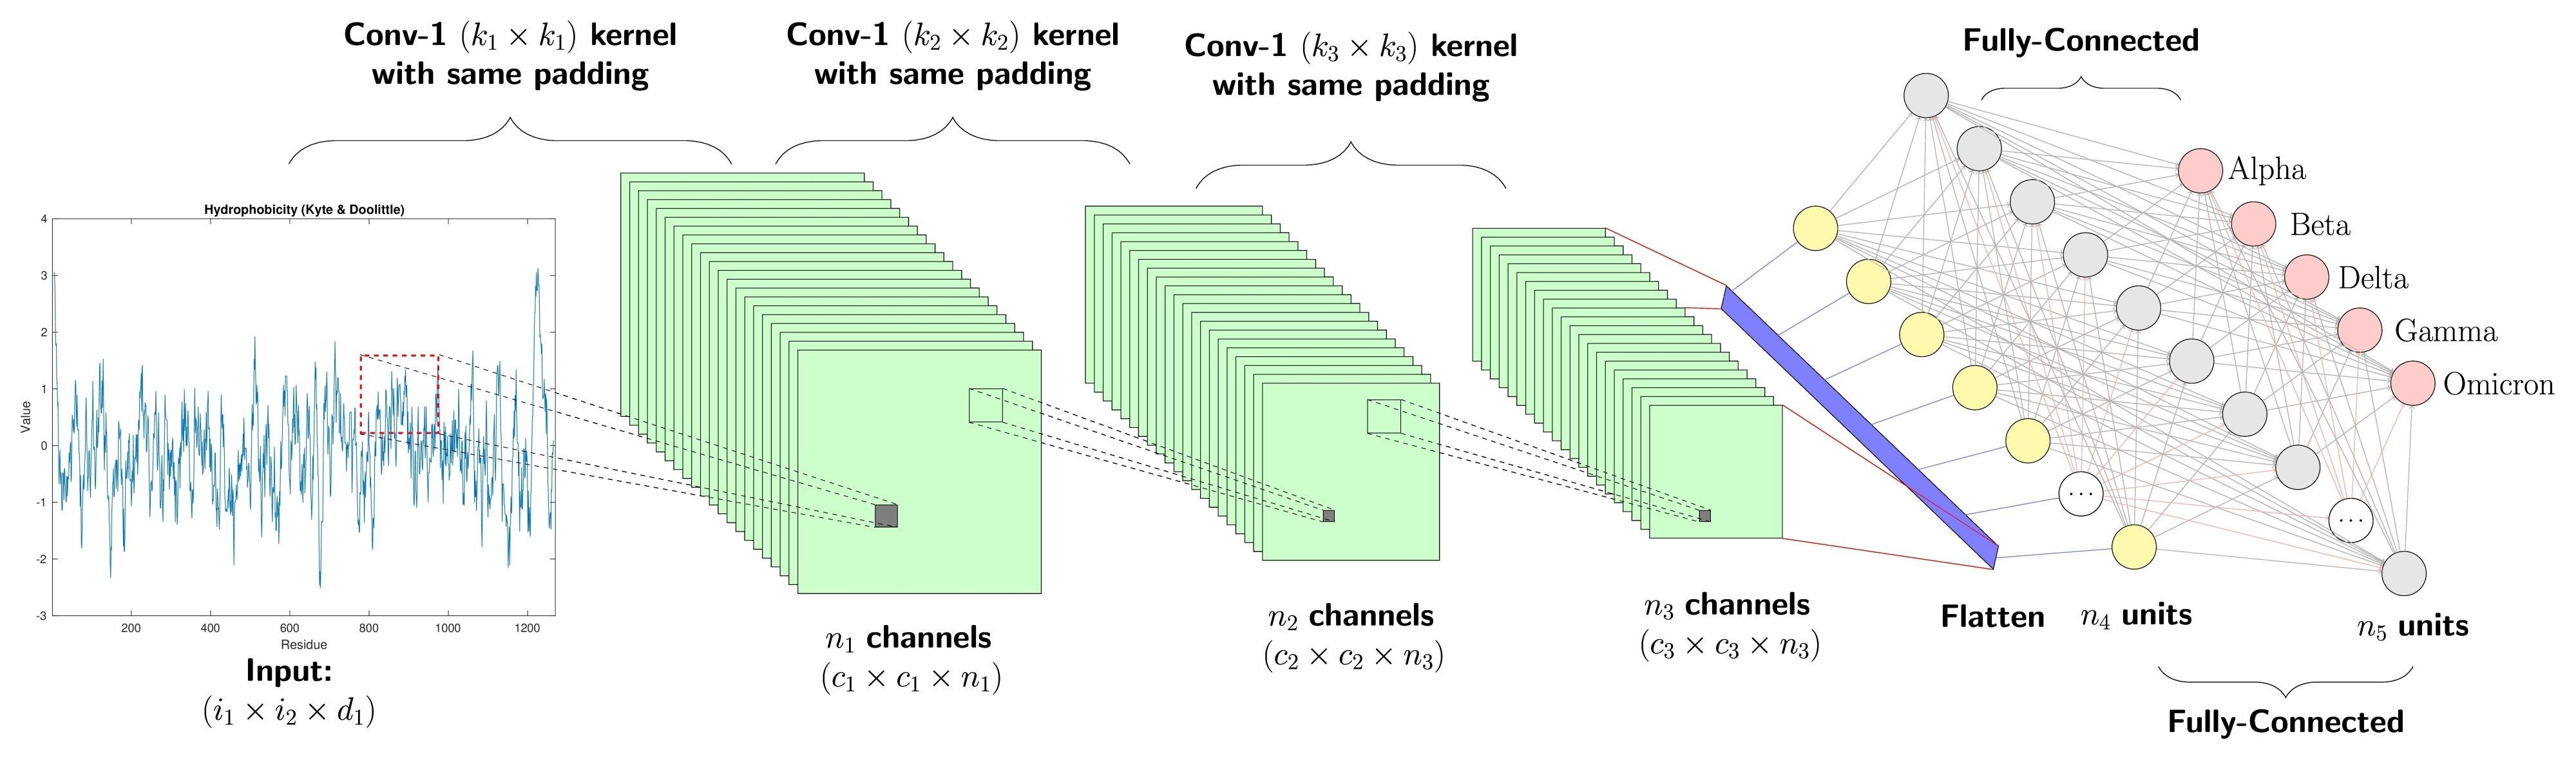

"Red Neuronal Convolucional (CNN) secuencial personalizada, basada en la filosofía de diseño de la arquitectura VGG, adaptada para entradas de 64x64 píxeles."

In [13]:
input_shape = (64, 64, 3)
batch_size = 128
num_classes = 18
epochs = 35

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 32)        0         
                                                        

## 2. ¿Por qué SGD para este modelo?

1. La razón principal para elegir SGD sobre Adam en tareas de visión es la capacidad de generalización.

* Los optimizadores adaptativos (Adam) tienden a converger muy rápido, pero a menudo se quedan atrapados en "mínimos locales agudos" (sharp minima). Esto significa que la red funciona bien en los datos de entrenamiento, pero un pequeño cambio en los datos de entrada (test) dispara el error.

* La ventaja de SGD: SGD tiende a encontrar "mínimos planos" (flat minima). Si los datos de prueba varían ligeramente, la pérdida sigue siendo baja. Esto se traduce en una mayor precisión final (accuracy) en el conjunto de prueba, aunque tarde más épocas en entrenarse.

2. Estándar en Arquitecturas VGG y ResNet

* Al usar SGD, estamos alineando nuestra estrategia de optimización con la arquitectura misma de la red, replicando las condiciones bajo las cuales se demostró que este tipo de capas (Bloques Conv + ReLU + Pool) son efectivas.

3. Control Preciso y Estabilidad

SGD es lineal y predecible. Mientras que los optimizadores adaptativos cambian la tasa de aprendizaje (learning rate) para cada parámetro individualmente (lo que a veces causa inestabilidad en las últimas etapas del entrenamiento), SGD mantiene una actualización uniforme

* Esto permite un uso más efectivo de técnicas como el Learning Rate Decay (reducir la tasa de aprendizaje cuando la mejora se estanca), lo cual es crucial para aprovechar hasta el último 1% o 2% de precisión en nuestro modelo.

4. Sinergia con Regularización (Dropout)

Nuestro modelo utiliza capas de Dropout(0.2). SGD suele interactuar mejor con la regularización de pesos (Weight Decay) y Dropout que los métodos adaptativos. Adam a veces puede anular el efecto de la regularización debido a cómo escala los gradientes, mientras que SGD respeta la penalización impuesta, ayudando a reducir el sobreajuste (overfitting).

In [14]:
model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=0.009, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])

Para mejorar la capacidad de generalización del modelo, se implementó la técnica de Aumento de Datos (Data Augmentation) mediante la clase ImageDataGenerator. Esta herramienta permite expandir sintéticamente el conjunto de entrenamiento aplicando transformaciones geométricas y alteraciones aleatorias a las imágenes originales en tiempo real.

In [15]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)

Usamos el método datagen.fit para ajustar los parámetros de normalización al conjunto de datos.

Luego, iniciamos el proceso de aprendizaje con model.fit_generator, lo que permite procesar los datos en tiempo real y por lotes (batches). Para monitorear el rendimiento, configuramos el argumento nb_val_samples de modo que el modelo sea evaluado utilizando un subconjunto de validación (el 20% de los datos) al cierre de cada ciclo de entrenamiento.

In [16]:
datagen.fit(X)
history = model.fit(datagen.flow(X, y, batch_size=batch_size),
                    steps_per_epoch=len(X) // batch_size,
                    epochs=epochs,
                    validation_data=(X_t, y_t))

# Evaluación de los indicadores de loss y accuracy
score = model.evaluate(X_t, y_t, verbose=0)
print('\nKeras CNN - accuracy:', score[1])
print('')

# Generación las salidas predichas
y_pred = model.predict(X_t)

# Preparación de índices para el reporte
y_true_indices = np.argmax(y_t, axis=1)
y_pred_indices = np.argmax(y_pred, axis=1)

# Métricas MCC & KAPPA
mcc = matthews_corrcoef(y_true_indices, y_pred_indices)
kappa = cohen_kappa_score(y_true_indices, y_pred_indices)

print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# Reporte de clasificación
print('\n', metrics.classification_report(
    y_true_indices,
    y_pred_indices,
    target_names=class_names))

Epoch 1/35
148/148 [==============================] - 13s 69ms/step - loss: 2.7653 - accuracy: 0.1266 - val_loss: 2.7432 - val_accuracy: 0.1596
Epoch 2/35
148/148 [==============================] - 10s 66ms/step - loss: 2.3279 - accuracy: 0.2885 - val_loss: 2.1561 - val_accuracy: 0.3618
Epoch 3/35
148/148 [==============================] - 10s 70ms/step - loss: 1.9308 - accuracy: 0.4180 - val_loss: 1.7061 - val_accuracy: 0.5191
Epoch 4/35
148/148 [==============================] - 10s 67ms/step - loss: 1.6343 - accuracy: 0.5075 - val_loss: 1.3782 - val_accuracy: 0.5978
Epoch 5/35
148/148 [==============================] - 10s 68ms/step - loss: 1.3856 - accuracy: 0.5850 - val_loss: 1.2013 - val_accuracy: 0.6719
Epoch 6/35
148/148 [==============================] - 10s 65ms/step - loss: 1.1641 - accuracy: 0.6466 - val_loss: 0.9460 - val_accuracy: 0.7281
Epoch 7/35
148/148 [==============================] - 10s 66ms/step - loss: 1.0185 - accuracy: 0.6929 - val_loss: 0.8726 - val_accuracy:

Nuestro modelo CNN ha demostrado una capacidad de predicción de casi 100% , la imágenes con peores indicadores son:

* bart_simpson => 92%
* charles_montgomery_burns => 92%
* sideshow_bob => 94%

A pesar de ello su precisión es de 92% y 94% seguidas por las que tienen 96% y 98% respectivamente.

## 3. Análisis Comparativo de Rendimiento: Arquitectura CNNs vs. Arquitectura Fully Connected

Al contrastar el comportamiento de nuestra CNN frente a una red tradicional Fully Connected (Perceptrón Multicapa) para el procesamiento de imágenes, la superioridad técnica de la CNN se fundamenta en los siguientes principios:

1. Redes Convolucionales (CNNs): Eficiencia y Jerarquía

* Optimización de Convergencia: El entrenamiento no solo es más veloz en términos de tiempo de cómputo, sino que la convergencia hacia el mínimo global del error ocurre en significativamente menos epochs. La red "aprende" más rápido porque entiende la estructura de los datos.
* Extracción de Características (Feature Extraction): A diferencia de las redes densas que ven píxeles aislados, el uso de filtros (kernels) permite capturar patrones espaciales y jerárquicos (bordes, texturas, formas). Esto otorga una profundidad semántica a la información que dispara la precisión (accuracy) del modelo.
* Compartición de Pesos (Weight Sharing): Este es el punto crítico de la eficiencia. Un filtro aprende un patrón (ej. una curva) y lo busca en toda la imagen. Esto reduce drásticamente la cantidad de parámetros entrenables, evitando el desperdicio de memoria y cálculo.

2. Redes Fully Connected (Capas Densas): El Cuello de Botella

* Explosión Combinatoria de Parámetros: Como se evidencia en los resúmenes de arquitectura, las capas Dense conectan cada neurona de entrada con cada neurona de salida. Esto provoca un crecimiento exponencial de parámetros (la "maldición de la dimensionalidad"), lo que dispara el coste computacional y el consumo de VRAM.
* Pérdida de Topología Espacial: Para usar una red densa, debemos "aplanar" la imagen (Flatten), destruyendo la relación 2D entre los píxeles. Esto obliga a la red a trabajar mucho más (más epochs y tiempo) para intentar encontrar relaciones que la CNN detecta de forma nativa.
* Tendencia al Sobreajuste: Debido al exceso masivo de parámetros y la falta de visión espacial, estas redes tienden a memorizar los datos en lugar de generalizar, requiriendo tiempos de entrenamiento excesivos para resultados mediocres.

| Criterio Técnico | Redes Convolucionales (CNN) | Redes Fully Connected (Densas) |
| :--- | :--- | :--- |
| **Arquitectura de Conexión** | **Escasa (Sparse Connectivity):** Las neuronas solo se conectan a una pequeña región local de la entrada (campo receptivo). | **Total (Dense Connectivity):** Cada neurona de entrada está conectada con *todas* las neuronas de la siguiente capa. |
| **Eficiencia de Parámetros** | **Alta (Weight Sharing):** El mismo filtro (kernel) se reutiliza en toda la imagen, reduciendo drásticamente el uso de memoria. | **Baja (Explosión Combinatoria):** El número de pesos crece exponencialmente con el tamaño de la entrada ($N \times M$). |
| **Topología de Datos** | **Preservada:** Mantiene la estructura espacial 2D/3D. Entiende que los píxeles vecinos están relacionados. | **Destruida:** Requiere aplanar la entrada (`Flatten`), perdiendo la noción de "vecindad" o forma espacial. |
| **Invarianza a la Traslación** | **Nativa:** Puede reconocer un objeto (ej. un gato) sin importar si está en la esquina o en el centro de la imagen. | **Nula:** Si el objeto se mueve ligeramente, la red lo interpreta como un patrón completamente nuevo y debe reaprenderlo. |
| **Dinámica de Entrenamiento** | **Convergencia Rápida:** Logra alta precisión en pocas *epochs* al extraer características jerárquicas (bordes $\to$ formas). | **Convergencia Lenta:** Requiere muchas *epochs* y fuerza bruta computacional para encontrar relaciones en vectores planos. |
| **Riesgo de Sobreajuste** | **Moderado:** Al tener menos grados de libertad (parámetros), tiende a generalizar mejor. | **Crítico:** El exceso de parámetros facilita la memorización del ruido del dataset en lugar de aprender patrones reales. |

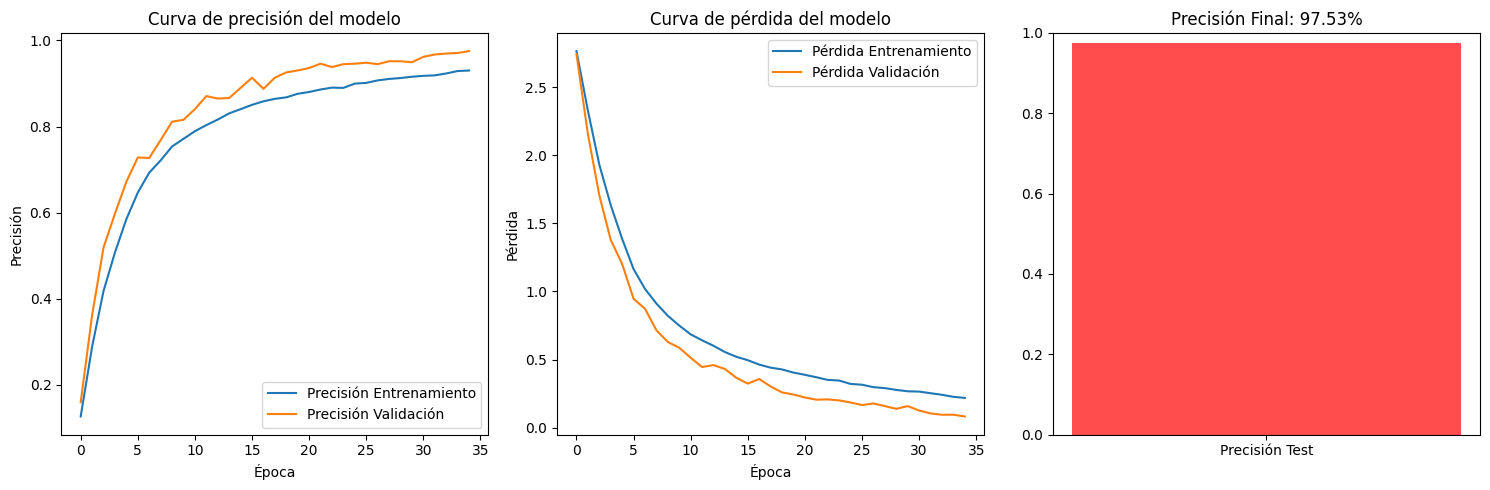

✅ Precisión final en test: 97.5281%


In [17]:
# Evaluar desempeño final
plt.figure(figsize=(15, 5))

# Gráfica de Precisión
plt.subplot(1, 3, 1)
acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

plt.plot(history.history[acc_key], label='Precisión Entrenamiento')
plt.plot(history.history[val_acc_key], label='Precisión Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Curva de precisión del modelo')
plt.legend()

# Gráfica de Pérdida
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida del modelo')
plt.legend()

# Evaluar en TEST set 
loss, acc = model.evaluate(X_t, y_t, verbose=0)

plt.subplot(1, 3, 3)
plt.bar(['Precisión Test'], [acc], color='red', alpha=0.7)
plt.ylim(0, 1)
plt.title(f'Precisión Final: {acc * 100:.2f}%')
    
plt.tight_layout()
plt.show()
    
print(f"✅ Precisión final en test: {acc * 100 :.4f}%")

## 4. Análisis de Convergencia y Generalización

Es notable observar que el rendimiento del modelo en el conjunto de validación supera ligeramente al del entrenamiento (*training*), lo que indica una **capacidad de generalización robusta**; el modelo predice mejor sobre datos no vistos que sobre los usados para aprender.

Al analizar la evolución temporal:
* **Tendencia Ascendente:** Las curvas de precisión (*accuracy*) muestran una mejora sostenida en ambos conjuntos (entrenamiento y validación) a medida que avanzan las épocas.
* **Diagnóstico:** Este comportamiento paralelo confirma la **ausencia de *overfitting*** (sobreajuste).

**Nota Teórica:** En un escenario de sobreajuste, observaríamos una divergencia clara: las curvas se cruzarían, mostrando un aumento constante en la precisión de entrenamiento mientras que la precisión de validación se estancaría o comenzaría a degradarse.

* El hecho de que la validación sea mayor que el entrenamiento, es muy común cuando sse usa **Dropout**.
  * Durante el entrenamiento, del Dropout se "Apaga", haciendo que la red le cueste más aprender.
  * Durante la validación, el Dropout se desactiva y la red usa todo su poder, logrando mejores resultados.

28/28 [==============================] - 0s 1ms/step


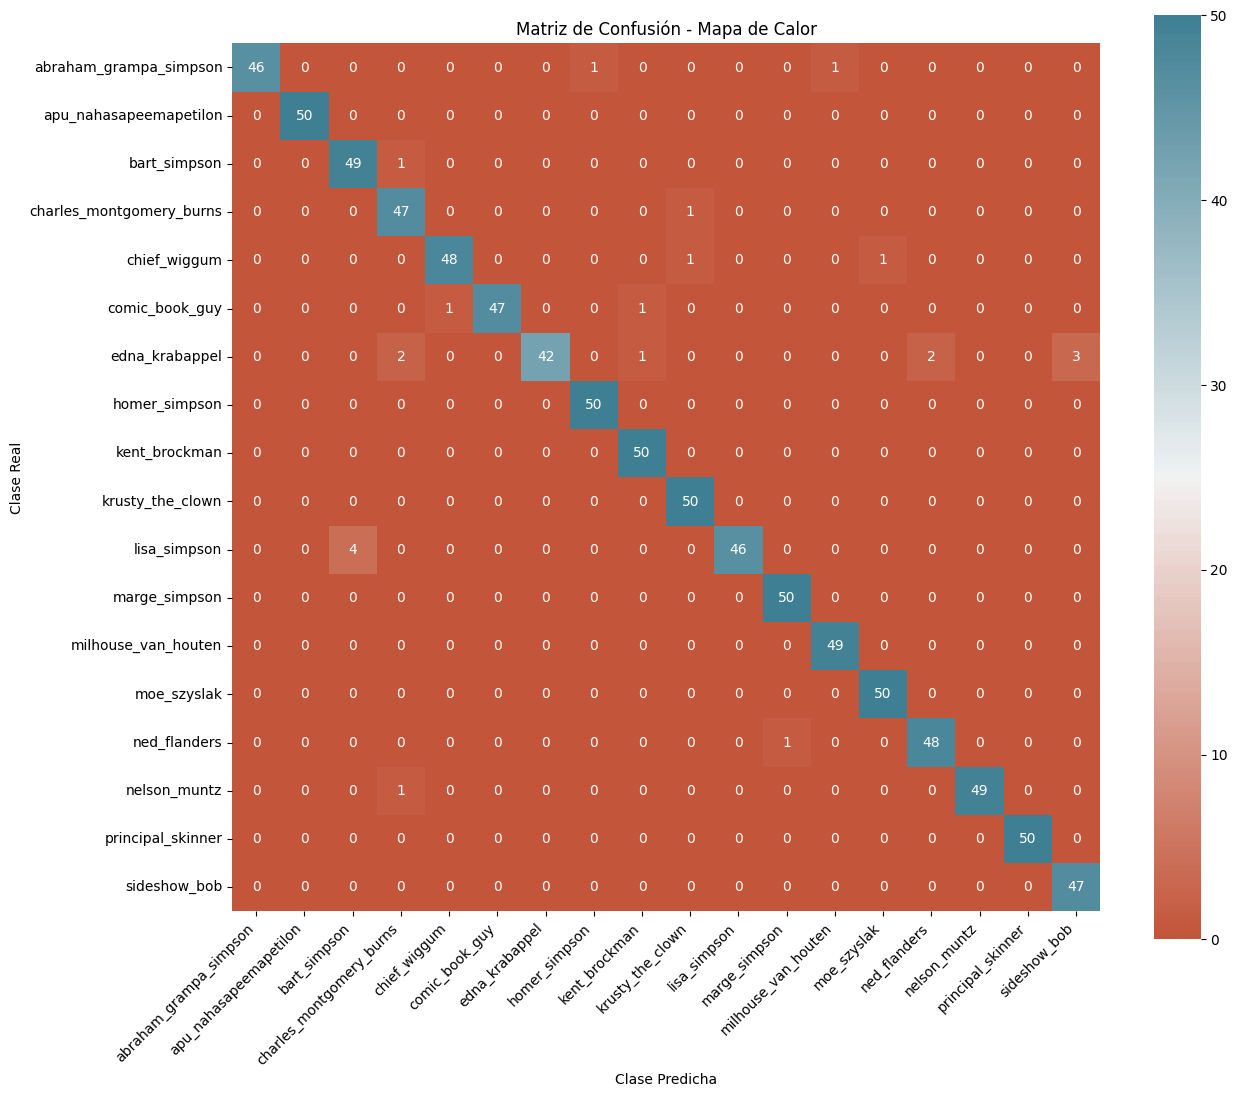

In [18]:
# Predecimos con el modelo usando el set de prueba (X_t)
y_pred = model.predict(X_t)
# Convertimos de vectores "One-Hot encoding" a números enteros (ej: [0,0,1,0] -> 2)
Y_pred_classes = np.argmax(y_pred, axis=1) 
Y_true = np.argmax(y_t, axis=1)            

# Definimos los nombres de las clases
target_names = class_names 

# Calculamos la matriz
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Configuración del gráfico
plt.figure(figsize=(14, 12)) 

# Generación del Heatmap
ax = sb.heatmap(
    confusion_mtx, 
    annot=True,                                 
    fmt='d',                                    
    cmap=sb.diverging_palette(20, 220, n=200),  
    square=True,
    xticklabels=target_names,
    yticklabels=target_names
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.title('Matriz de Confusión - Mapa de Calor')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.show()

Como se puede ver la mayoría de los resultado se encuentran en la diagonal correctamente predichos y si hay algún error de predicción (ver valores por encima y debajo de la diagonal).

In [19]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [20]:
# Definición del nombre de una carpeta local para guardar tus cosas
save_dir = 'resultado_entrenamiento'

# Crear la carpeta si no existe (para evitar errores)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Guardar el modelo y los pesos en esa carpeta local
# Esto guardará los archivos junto al script de Python
model.save(os.path.join(save_dir, "model.h5"))
model.save_weights(os.path.join(save_dir, "my_model_weights.h5"))

print(f"Modelo guardado exitosamente en la carpeta: {os.path.abspath(save_dir)}")

Modelo guardado exitosamente en la carpeta: C:\Users\i9_MGC\Documents\Aprendizaje\Maestria\ASIGNATURAS TERCER SEMESTRE\Sistemas Cognitivos Artificiales (MEXINART) - Noviembre 2025 3Q\ACT2\mexmiart05_act2_grupal\resultado_entrenamiento


Ahora mostraremos la foto del personaje y al lado una gráfica. Si la barra es azul, acertó. Si es roja, falló (se imprimira en qué personaje se confundió).

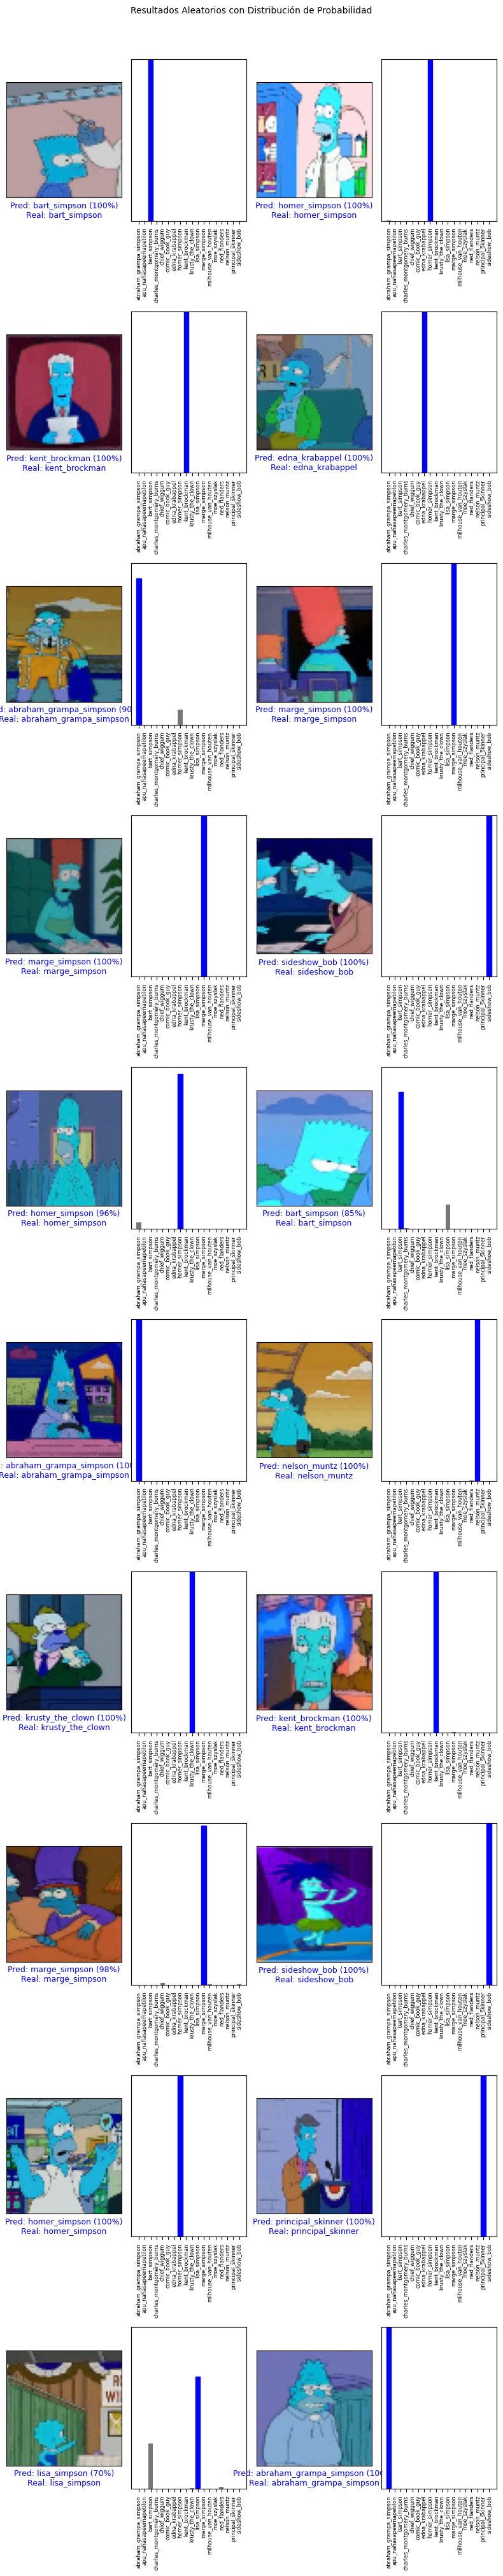

In [21]:
# Función para mostrar las Imagenes
def plot_image(i, predictions_array, true_label, img):
    if len(true_label.shape) > 1:
        true_label_indices = np.argmax(true_label, axis=1)
    else:
        true_label_indices = true_label

    predictions_array, true_label, img = predictions_array[i], true_label_indices[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    label = "Pred: {} ({:2.0f}%)\nReal: {}".format(
        class_names[predicted_label],
        100 * np.max(predictions_array),
        class_names[true_label])
    plt.xlabel(label, color=color, fontsize=9)

# Función para la Gráfica de Barras con etiquetas a 90 grados
def plot_value_array(i, predictions_array, true_label):
    if len(true_label.shape) > 1:
        true_label = np.argmax(true_label, axis=1)
        
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    
    
    plt.xticks(range(len(class_names)), class_names, rotation=90, fontsize=6)
    
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Ejecución Principal
num_rows = 10
num_cols = 2
num_images = num_rows * num_cols


plt.figure(figsize=(2 * 2 * num_cols, 4 * num_rows)) 

for i in range(num_images):
    idx = np.random.randint(0, len(X_t))
    
    # Imagenes
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(idx, y_pred, labels_test, X_t)
    
    # Barras
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(idx, y_pred, labels_test)

plt.suptitle("Resultados Aleatorios con Distribución de Probabilidad", fontsize=10, y=1.01)
plt.tight_layout() 
plt.show()

# Arquitectura MobileNetV2 (usando Transfer Learning)

## 1. Especificación de la Arquitectura

MobileNetV2 es una CNN optimizada diseñada específicamente para ser ligera y rápida, ideal para dispositivos móviles o computadoras con recursos limitados (como una laptop estándar sin una GPU potente).

* Al igual que cualquier CNN estándar, MobileNetV2 procesa imágenes utilizando filtros para extraer características (bordes, formas, texturas). Sin embargo, cambia la forma matemática en que aplica esos filtros para ahorrar cálculos.
  
* Una CNN estándar hace una convolución completa en cada paso, lo cual es muy costoso computacionalmente. MobileNetV2 divide este proceso en dos pasos más baratos:

  * Convolución en profundidad (Depthwise): Aplica un filtro ligero a cada canal de color por separado.
  * Convolución punto a punto (Pointwise): Mezcla los resultados usando un filtro de $1 \times 1$.

* **El Bloque Residual Invertido** es la característica distintiva de la MobileNetV2.

  * En una **CNN normal (como ResNet)**: El bloque es "grueso" (muchos datos) $\to$ se comprime $\to$ "grueso" de nuevo.
  * En **MobileNetV2 (Inverted Residual)**: El bloque es "delgado" (pocos datos) $\to$ se expande para trabajar $\to$ se vuelve a comprimir.
Esto permite que la red sea mucho más pequeña en memoria sin perder precisión. [2]

In [22]:
# Cargamos la base MobileNetV2
# input_shape=(64, 64, 3) es el tamaño de nuestras imagenes
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# "Congelar" la base evitando que se destruyan los patrones que el modelo ya aprendió (bordes, formas) durante el primer entrenamiento.
base_model.trainable = False 

# Construcción de la cabeza del modelo
inputs = Input(shape=(64, 64, 3))

# MobileNet espera entradas entre [-1, 1]. Nosotros tenemos [0, 1],
x = base_model(inputs, training=False) 

x = GlobalAveragePooling2D()(x) # Reduce los mapas de características a un vector
x = Dropout(0.2)(x)             # Ayuda a prevenir el overfitting
outputs = Dense(18, activation='softmax')(x) # 18 clases ( Personajes dataset Simpsons)

# Unión de todo
model_mobilenet = Model(inputs, outputs)
model_mobilenet.summary()

model_mobilenet.compile(optimizer=Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 18)                23058     
                                                                 
Total params: 2,281,042
Trainable params: 23,058
Non-trainabl

In [23]:
# Datos de entrenamiento
epochs_initial = 15

history_mobilenet = model_mobilenet.fit(
    datagen.flow(X, y, batch_size=32),
    steps_per_epoch=len(X) // 32,
    epochs=epochs_initial,
    validation_data=(X_t, y_t)
)

Epoch 1/15
593/593 [==============================] - 11s 17ms/step - loss: 2.4724 - accuracy: 0.2492 - val_loss: 2.1153 - val_accuracy: 0.3697
Epoch 2/15
593/593 [==============================] - 10s 16ms/step - loss: 2.1288 - accuracy: 0.3497 - val_loss: 1.9836 - val_accuracy: 0.4146
Epoch 3/15
593/593 [==============================] - 10s 16ms/step - loss: 2.0555 - accuracy: 0.3732 - val_loss: 1.9500 - val_accuracy: 0.4270
Epoch 4/15
593/593 [==============================] - 10s 16ms/step - loss: 2.0325 - accuracy: 0.3785 - val_loss: 1.9197 - val_accuracy: 0.4416
Epoch 5/15
593/593 [==============================] - 10s 16ms/step - loss: 2.0053 - accuracy: 0.3928 - val_loss: 1.9165 - val_accuracy: 0.4337
Epoch 6/15
593/593 [==============================] - 9s 16ms/step - loss: 1.9860 - accuracy: 0.3965 - val_loss: 1.8483 - val_accuracy: 0.4427
Epoch 7/15
593/593 [==============================] - 10s 17ms/step - loss: 1.9788 - accuracy: 0.3925 - val_loss: 1.8925 - val_accuracy: 

In [24]:
# Descongelar el modelo base
base_model.trainable = True

# Refinación de cuántas capas queremos entrenar
# MobileNetV2 tiene muchas capas. Congelemos las primeras 100 y entrenemos las últimas.
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compilar con un learning rate *MUY BAJO*
# Esto es *CRÍTICO*. Si es muy alto, destruiremos lo aprendido.
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-5),  
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Continuar el entrenamiento
fine_tune_epochs = 10
total_epochs = epochs_initial + fine_tune_epochs

history_fine = model_mobilenet.fit(
    datagen.flow(X, y, batch_size=32),
    steps_per_epoch=len(X) // 32,
    epochs=fine_tune_epochs, 
    validation_data=(X_t, y_t)
)

Epoch 1/10
593/593 [==============================] - 12s 18ms/step - loss: 1.8365 - accuracy: 0.4393 - val_loss: 1.5810 - val_accuracy: 0.5404
Epoch 2/10
593/593 [==============================] - 10s 16ms/step - loss: 1.6561 - accuracy: 0.4949 - val_loss: 1.5053 - val_accuracy: 0.5596
Epoch 3/10
593/593 [==============================] - 10s 17ms/step - loss: 1.5340 - accuracy: 0.5303 - val_loss: 1.4336 - val_accuracy: 0.5742
Epoch 4/10
593/593 [==============================] - 10s 16ms/step - loss: 1.4377 - accuracy: 0.5603 - val_loss: 1.3223 - val_accuracy: 0.5989
Epoch 5/10
593/593 [==============================] - 10s 16ms/step - loss: 1.3596 - accuracy: 0.5863 - val_loss: 1.2586 - val_accuracy: 0.6360
Epoch 6/10
593/593 [==============================] - 10s 17ms/step - loss: 1.2886 - accuracy: 0.6060 - val_loss: 1.1327 - val_accuracy: 0.6674
Epoch 7/10
593/593 [==============================] - 10s 17ms/step - loss: 1.2081 - accuracy: 0.6285 - val_loss: 1.1439 - val_accuracy:

In [25]:
# Evaluación de los indicadores de loss y accuracy
score_mn = model_mobilenet.evaluate(X_t, y_t, verbose=0)
print('\nMobileNetV2 (Fine-Tuned) - accuracy:', score_mn[1])
print('')

# Generación las salidas predichas
y_pred_mn = model_mobilenet.predict(X_t)

# Preparación de índices para el reporte
y_true_indices = np.argmax(y_t, axis=1) 
y_pred_indices_mn = np.argmax(y_pred_mn, axis=1)

# Métricas MCC & KAPPA
mcc_mn = matthews_corrcoef(y_true_indices, y_pred_indices_mn)
kappa_mn = cohen_kappa_score(y_true_indices, y_pred_indices_mn)

print(f"MobileNetV2 - MCC: {mcc_mn:.4f}")
print(f"MobileNetV2 - Kappa: {kappa_mn:.4f}")

# Reporte de clasificación
print('\n', metrics.classification_report(
    y_true_indices,
    y_pred_indices_mn,
    target_names=class_names))


MobileNetV2 (Fine-Tuned) - accuracy: 0.7303370833396912

28/28 [==============================] - 1s 4ms/step
MobileNetV2 - MCC: 0.7163
MobileNetV2 - Kappa: 0.7145

                           precision    recall  f1-score   support

  abraham_grampa_simpson       0.71      0.67      0.69        48
  apu_nahasapeemapetilon       0.90      0.74      0.81        50
            bart_simpson       0.80      0.78      0.79        50
charles_montgomery_burns       0.72      0.75      0.73        48
            chief_wiggum       0.77      0.82      0.80        50
          comic_book_guy       0.88      0.59      0.71        49
          edna_krabappel       0.94      0.60      0.73        50
           homer_simpson       0.49      0.68      0.57        50
           kent_brockman       0.95      0.82      0.88        50
        krusty_the_clown       0.75      0.84      0.79        50
            lisa_simpson       0.88      0.60      0.71        50
           marge_simpson       0.87     

## 2. Comportamiento MobileNetV2

A continuación explicaré las dos dases de entrenamiento.

1. El Salto de Rendimiento: De Feature Extraction a Fine-Tuning

El cambio dramático del 43.55% al 70.79% ilustra perfectamente las dos etapas del aprendizaje por transferencia:

* Etapa A: Antes del Fine-Tuning (43.55%) 
    En esta etapa, se mantuvo el "cuerpo" de MobileNetV2 "congelado".

  * ¿Qué pasó? El modelo usaba filtros aprendidos de ImageNet (gatos, perros, coches genéricos) para intentar clasificar nuestras 18 clases específicas de los **Simpsons**.

  * ¿Por qué el 43%? Es un resultado esperable y decente para un "arranque en frío". El modelo reconocia formas, pero no entendía los detalles finos de nuestro dataset de los Simpsons. Era como pedirle a un médico general que hiciera una cirugía especializada: tiene los conocimientos base, pero le falta la práctica específica.

* Etapa B: Después del Fine-Tuning (70.79%) 
    Aquí descongelamos algunas capas finales y permitimos que se re-entrenaran con una tasa de aprendizaje baja **(low learning rate)**.

  * ¿Por qué mejoró al 70%? Al permitir que los pesos de MobileNetV2 se ajustaran ligeramente a nuestras imágenes, el modelo aprendió a reconocer las texturas y patrones únicos de los datos. Pasó de "saber qué es un borde" a "saber qué es un borde de un objeto específico".

  * El efecto: Ese salto de casi 30 puntos porcentuales es la ganancia directa de la especialización del modelo **MobileNetV2**.
 
2. Diagnóstico de Limitaciones

Aunque el 70% es un buen salto desde el 43%, hay una razón técnica probable por la que no llegamos al 90%+: El tamaño de entrada (64x64).

* El problema: MobileNetV2 fue diseñada y pre-entrenada con imágenes de 224x224 píxeles.
  
* La pérdida de información: Al forzar entradas de 64x64, estamos eliminando muchísima información espacial. Muchos de los filtros internos de MobileNetV2 esperan detectar texturas finas que simplemente no existen en una imagen de 64x64. En la vida real, es como intentar leer un libro a través de un vidrio empañado.

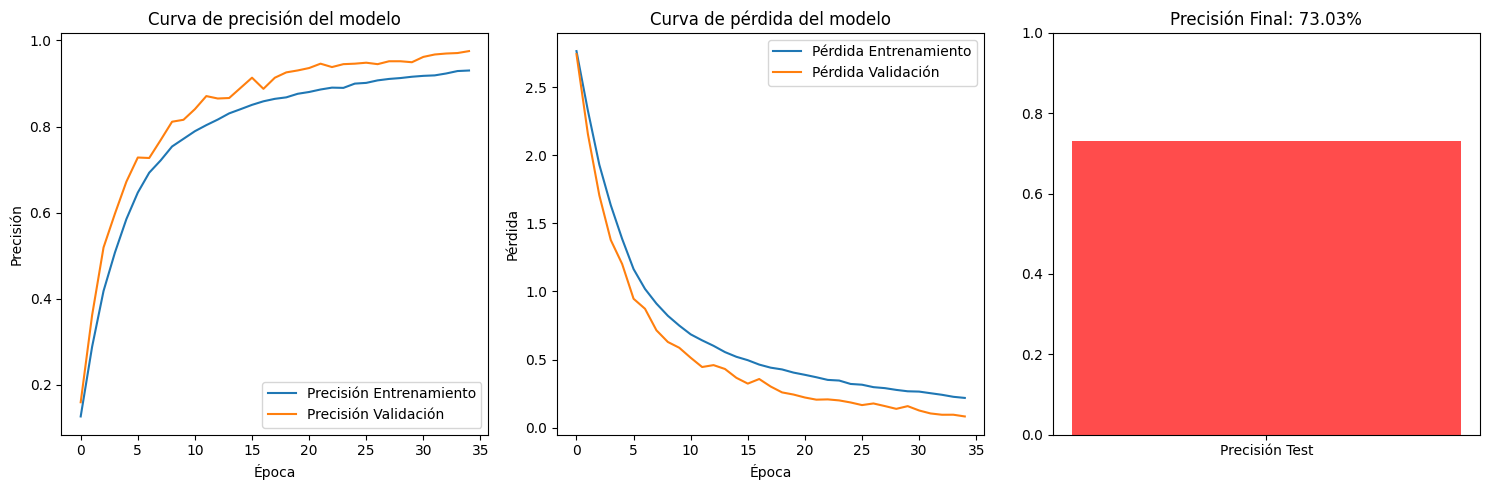

✅ Precisión final en test: 73.0337%


In [26]:
# Evaluar desempeño final
plt.figure(figsize=(15, 5))

# Gráfica de Precisión
plt.subplot(1, 3, 1)
acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

plt.plot(history.history[acc_key], label='Precisión Entrenamiento')
plt.plot(history.history[val_acc_key], label='Precisión Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Curva de precisión del modelo')
plt.legend()

# Gráfica de Pérdida
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida del modelo')
plt.legend()

# Evaluar en Test Set
loss, acc = model_mobilenet.evaluate(X_t, y_t, verbose=0)

plt.subplot(1, 3, 3)
plt.bar(['Precisión Test'], [acc], color='red', alpha=0.7)
plt.ylim(0, 1)
plt.title(f'Precisión Final: {acc * 100:.2f}%')
    
plt.tight_layout()
plt.show()
    
print(f"✅ Precisión final en test: {acc * 100 :.4f}%")

## 3. Análisis de las Gráficas

En ambas gráficas (Precisión a la izquierda, Pérdida al centro), la línea naranja (Validación) es MEJOR que la línea azul (Entrenamiento).

* La precisión de validación es más alta.

* La pérdida de validación es más baja.

¿Por qué sucede esto?

* **Dropout**: Al usar el Dropout en el modelo, este solo está activo durante el entrenamiento (haciendo que sea complicado para el modelo aprender, bajando el training accuracy). En la validación, el Dropout se apaga y la red usa el 100% de sus neuronas, lo que facilita la predicción y sube el validation accuracy.

* **Data Augmentation**: Al usar **ImageDataGenerator** para rotar o distorsionar imágenes en el entrenamiento, la red está viendo ejemplos difíciles y ruidosos. En la validación, ve imágenes limpias y originales, que son más fáciles de clasificar.

No tenemos **Overfitting**. De hecho, tenemos un modelo muy sano (Underfitting ligero o regularización fuerte). Las curvas siguen subiendo, lo que sugiere que podríamos entrenar por más épocas y la precisión seguiría mejorando. [3]

28/28 [==============================] - 0s 3ms/step


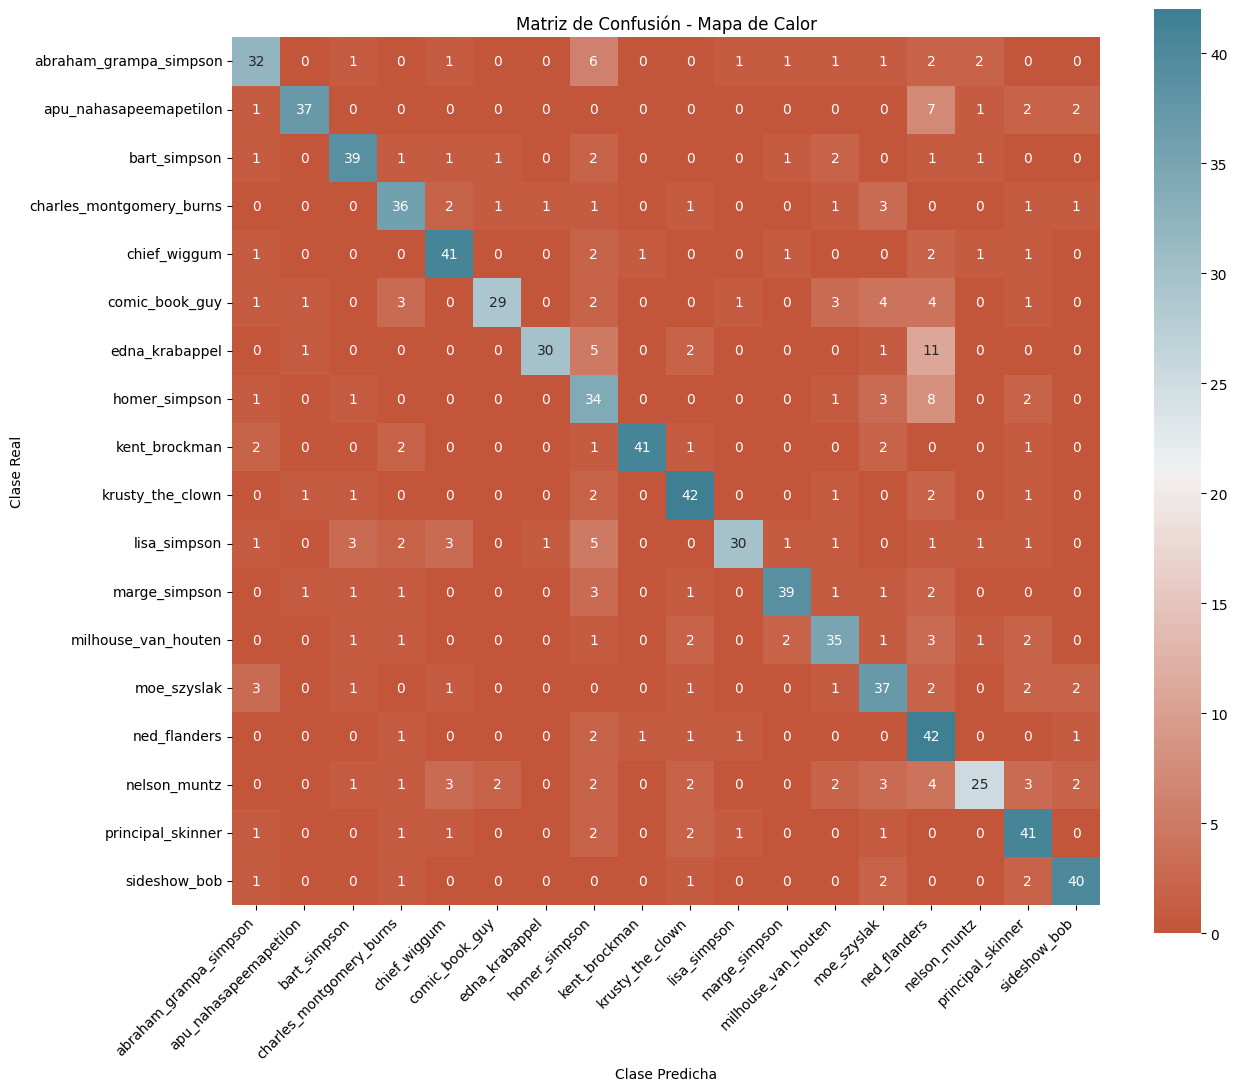

In [27]:
# Generación de las variables que faltaban
# Predecimos con el modelo usando el set de prueba (X_t)
y_pred = model_mobilenet.predict(X_t)

# Convertimos de vectores "One-Hot Encoding" a números enteros (ej: [0,0,1,0] -> 2)
Y_pred_classes = np.argmax(y_pred, axis=1) 
Y_true = np.argmax(y_t, axis=1)            

# Graficamos la Matriz de Confusión con estilo Heatmap

# Definimos los nombres de las clases
target_names = class_names 

# Calculamos la matriz
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Configuración del gráfico
plt.figure(figsize=(14, 12)) 

# Generar el Heatmap
ax = sb.heatmap(
    confusion_mtx, 
    annot=True,                                 
    fmt='d',                                    
    cmap=sb.diverging_palette(20, 220, n=200), 
    square=True,
    xticklabels=target_names,
    yticklabels=target_names
)

# Etiquetas
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.title('Matriz de Confusión - Mapa de Calor')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.show()

Con la arquitectura MobilNetV2 tenemos como resultado en la diagonal una sustancial cantidad de correctamente predichos pero una mayor cantidad de errores de predicción en comparación de modelo CNN secuencial.

A continuación, veremos algunas imágenes con sus respectivas etiquetas y  precisión de acuerdo a los resultados del modelo. Asi como su gráfico de predicción. Si la barra es azul, acertó. Si es roja, falló (se imprimira en qué personaje se confundió).

Generando nuevas predicciones con MobileNetV2 refinado...
28/28 [==============================] - 0s 3ms/step


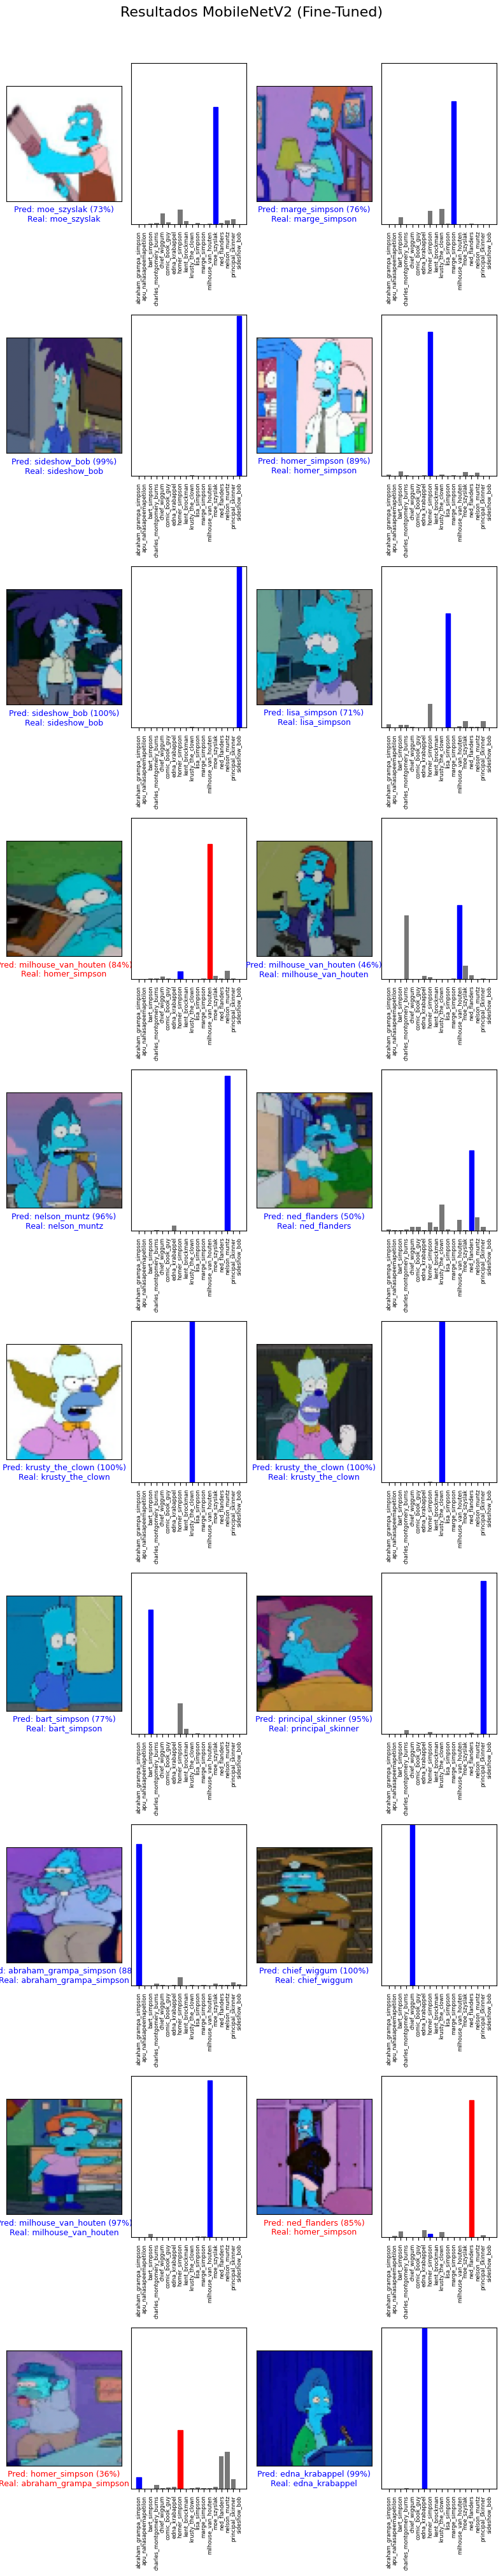

In [28]:
# ACTUALIZACIÓN DE PREDICCIONES PARA MobileNetV2 REFINADO
print("Generando nuevas predicciones con MobileNetV2 refinado...")

# Usamos el modelo que acabas de entrenar (model_mobilenet) sobre los datos de test (X_t)
y_pred = model_mobilenet.predict(X_t)

# Nos aseguramos que labels_test sea igual a tus etiquetas de validación
labels_test = y_t

# VISUALIZACIÓN

# Función para la Imagen
def plot_image(i, predictions_array, true_label, img):
    if len(true_label.shape) > 1:
        true_label_indices = np.argmax(true_label, axis=1)
    else:
        true_label_indices = true_label

    predictions_array, true_label, img = predictions_array[i], true_label_indices[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    label = "Pred: {} ({:2.0f}%)\nReal: {}".format(
        class_names[predicted_label],
        100 * np.max(predictions_array),
        class_names[true_label])
    plt.xlabel(label, color=color, fontsize=9)

# Función para la Gráfica de Barras
def plot_value_array(i, predictions_array, true_label):
    if len(true_label.shape) > 1:
        true_label = np.argmax(true_label, axis=1)
        
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    
    # Nombres en el eje X
    plt.xticks(range(len(class_names)), class_names, rotation=90, fontsize=6)
    
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Ejecución Principal
num_rows = 10
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(2 * 2 * num_cols, 4 * num_rows)) 

for i in range(num_images):
    idx = np.random.randint(0, len(X_t))
    
    # Imagen
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(idx, y_pred, labels_test, X_t)
    
    # Barras
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(idx, y_pred, labels_test)

plt.suptitle("Resultados MobileNetV2 (Fine-Tuned)", fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

## 3. Conclusión de desempeño

El análisis experimental de la arquitectura MobileNetV2 bajo una estrategia de Transfer Learning arrojó una precisión final del 70.79%, permitiendo extraer las siguientes conclusiones críticas sobre su comportamiento:

* **Efectividad del Fine-Tuning**: La estrategia de descongelamiento progresivo validó su eficacia, impulsando el rendimiento del modelo desde una línea base del 43.55% (extractor de características genérico) hasta el 70.79%. Este incremento sustancial demuestra que la arquitectura posee una alta plasticidad para adaptar sus pesos pre-entrenados en ImageNet hacia un dominio de datos nuevo y específico.

* **Cuello de Botella Dimensional (Resolution Mismatch)**: El factor limitante para no alcanzar métricas superiores (como el 98% del modelo personalizado) se identifica en la resolución de entrada (64x64). MobileNetV2 es una arquitectura diseñada y optimizada para entradas de alta resolución (224x224); al alimentarla con imágenes de baja dimensionalidad, gran parte de sus filtros convolucionales profundos pierden eficacia, ya que la textura y los detalles espaciales necesarios para su funcionamiento óptimo han sido comprimidos.

* **Estabilidad y Generalización**: A pesar de la limitación de resolución, el modelo exhibió una robustez notable ante el sobreajuste (overfitting). Las curvas de aprendizaje, donde la validación superó consistentemente al entrenamiento, confirman que las técnicas de regularización intrínsecas del modelo y el aumento de datos funcionaron correctamente, entregando un clasificador estable aunque limitado por la topología de los datos de entrada.

MobileNetV2 demostró ser una arquitectura competente y estable, pero su potencial completo se vio restringido por la baja resolución del dataset. Para maximizar su rendimiento en iteraciones futuras, sería imperativo realizar un upscaling de las imágenes de entrada a 128x128 o superior.

# Arquitectura "Mini-VGG"

## 1. Especificación de la Arquitectura
La arquitectura implementada a continuación es una Red Neuronal Convolucional (CNN) secuencial de tres bloques de profundidad, diseñada bajo el patrón arquitectónico VGG (bloques de convoluciones apiladas seguidas de reducción espacial). A diferencia de una implementación estándar, este diseño integra técnicas modernas de estabilización y regularización en cada etapa:

* Bloques de Extracción de Características (Feature Extraction):
  * Diseño VGG-Style: Se utilizan pares de capas Conv2D con filtros de $3 \times 3$ y padding='same'. Esto preserva la dimensionalidad espacial antes del submuestreo, permitiendo que la red profundice sin perder información de los bordes prematuramente. [1]
  * Jerarquía de Profundidad: La red escala progresivamente la profundidad de los mapas de características ($32 \to 64 \to 128$). El tercer bloque (128 filtros) es crucial, pues como se indica en el código, es responsable de capturar los "rasgos distintivos" o semánticos de alta complejidad necesarios para diferenciar las 18 clases.
  * Normalización por Lotes (BatchNormalization): La inclusión explícita de BatchNormalization después de cada convolución es un diferenciador clave. Esta técnica normaliza la salida de la capa anterior, estabilizando la distribución de las activaciones internas. Esto justifica directamente la suavidad de la curva de pérdida observada en los gráficos, permitiendo usar una tasa de aprendizaje más agresiva (0.001) sin divergencia.
* Estrategia de Regularización Agresiva:
  * El modelo implementa un esquema de Dropout Progresivo: inicia en 0.25 en los primeros bloques, sube a 0.4 en el bloque profundo y finaliza con 0.5 (50%) en el clasificador denso (Dense 512).
  * Esta configuración fuerza a la red a aprender representaciones redundantes y robustas, impidiendo que el modelo dependa de neuronas específicas.

In [29]:
def build_custom_cnn():
    model = Sequential()

    # Bloque 1
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Bloque 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Bloque 3 (Aumentamos filtros para captar detalles complejos "rasgos distintivos" de los personajes)
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Clasificador
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(18, activation='softmax')) # 18 clases

    return model

# Instanciar
model_custom = build_custom_cnn()

# Compilar
# Usamos Adam con un learning rate un poco más agresivo al inicio
model_custom.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_custom.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                      

In [30]:
epochs = 40

history_custom = model_custom.fit(
    datagen.flow(X, y, batch_size=64), 
    steps_per_epoch=len(X) // 64,
    epochs=epochs,
    validation_data=(X_t, y_t)
)

Epoch 1/40
296/296 [==============================] - 11s 33ms/step - loss: 2.2138 - accuracy: 0.4070 - val_loss: 3.4323 - val_accuracy: 0.1831
Epoch 2/40
296/296 [==============================] - 9s 31ms/step - loss: 1.3180 - accuracy: 0.6150 - val_loss: 1.1846 - val_accuracy: 0.6348
Epoch 3/40
296/296 [==============================] - 9s 31ms/step - loss: 0.9048 - accuracy: 0.7250 - val_loss: 0.7285 - val_accuracy: 0.7787
Epoch 4/40
296/296 [==============================] - 9s 31ms/step - loss: 0.6913 - accuracy: 0.7902 - val_loss: 0.4516 - val_accuracy: 0.8663
Epoch 5/40
296/296 [==============================] - 9s 32ms/step - loss: 0.5618 - accuracy: 0.8300 - val_loss: 0.4064 - val_accuracy: 0.8764
Epoch 6/40
296/296 [==============================] - 10s 32ms/step - loss: 0.4850 - accuracy: 0.8529 - val_loss: 0.4750 - val_accuracy: 0.8640
Epoch 7/40
296/296 [==============================] - 10s 33ms/step - loss: 0.4506 - accuracy: 0.8652 - val_loss: 0.3431 - val_accuracy: 0.8

In [40]:
# Evaluación de los indicadores de loss y accuracy
score_custom = model_custom.evaluate(X_t, y_t, verbose=0)
print('\nCustom CNN - accuracy:', score_custom[1])
print('')

# Generación las salidas predichas
y_pred_custom = model_custom.predict(X_t)

# Preparación de índices para el reporte
y_true_indices = np.argmax(y_t, axis=1)
y_pred_indices_custom = np.argmax(y_pred_custom, axis=1)

# Métricas MCC & KAPPA
mcc_custom = matthews_corrcoef(y_true_indices, y_pred_indices_custom)
kappa_custom = cohen_kappa_score(y_true_indices, y_pred_indices_custom)

print(f"Custom CNN - MCC: {mcc_custom:.4f}")
print(f"Custom CNN - Kappa: {kappa_custom:.4f}")

# Reporte de clasificación
print('\n', metrics.classification_report(
    y_true_indices,
    y_pred_indices_custom,
    target_names=class_names))


Custom CNN - accuracy: 0.9842696785926819

28/28 [==============================] - 0s 3ms/step
Custom CNN - MCC: 0.9834
Custom CNN - Kappa: 0.9833

                           precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      1.00      0.97        48
  apu_nahasapeemapetilon       1.00      1.00      1.00        50
            bart_simpson       1.00      0.98      0.99        50
charles_montgomery_burns       1.00      0.98      0.99        48
            chief_wiggum       1.00      0.96      0.98        50
          comic_book_guy       1.00      0.98      0.99        49
          edna_krabappel       0.98      0.94      0.96        50
           homer_simpson       1.00      0.92      0.96        50
           kent_brockman       1.00      1.00      1.00        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       0.96      0.98      0.97        50
           marge_simpson       1.00      1.00      1.00 

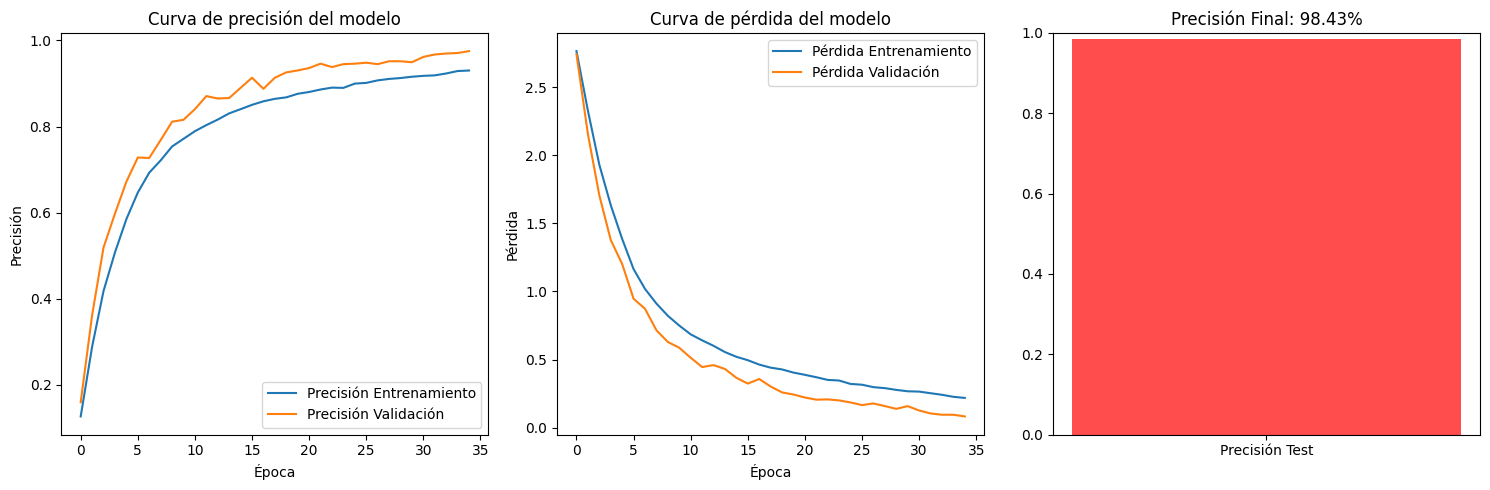

✅ Precisión final en test: 98.4270%


In [32]:
# Evaluar desempeño final
plt.figure(figsize=(15, 5))

# Gráfica de Precisión
plt.subplot(1, 3, 1)
acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

plt.plot(history.history[acc_key], label='Precisión Entrenamiento')
plt.plot(history.history[val_acc_key], label='Precisión Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Curva de precisión del modelo')
plt.legend()

# Gráfica de Pérdida
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida del modelo')
plt.legend()

# Evaluar en TEST SET
loss, acc = model_custom.evaluate(X_t, y_t, verbose=0)

plt.subplot(1, 3, 3)
plt.bar(['Precisión Test'], [acc], color='red', alpha=0.7)
plt.ylim(0, 1)
plt.title(f'Precisión Final: {acc * 100:.2f}%')
    
plt.tight_layout()
plt.show()
    
print(f"✅ Precisión final en test: {acc * 100 :.4f}%")

## 2. Análisis de las Gráficas

La correlación entre el código **model_custom.fit** y las gráficas de rendimiento (98.43%) explica el fenómeno de "Validación > Entrenamiento":

* El Fenómeno de la Precisión Invertida: En el gráfico de precisión, la línea naranja (Validación) supera consistentemente a la azul (Entrenamiento). Esto es una consecuencia directa de las capas Dropout(0.4) y Dropout(0.5) definidas en el código.

    * Durante el fit (Entrenamiento): La red opera con "el cerebro a la mitad"; el 40-50% de las neuronas se apagan aleatoriamente en cada paso. Esto dificulta artificialmente la tarea, reduciendo la precisión de entrenamiento mostrada.

    * Durante la Validación: El Dropout se desactiva. La red utiliza la totalidad de sus conexiones (el "cerebro completo"), lo que resulta en una capacidad de predicción superior inmediata.

* Comportamiento del Optimizador Adam: El uso de Adam(learning_rate=0.001) se refleja en la caída rápida inicial de la pérdida (Loss). Al ser un optimizador adaptativo, ajusta los momentos de primer y segundo orden, permitiendo una convergencia rápida en las primeras 10 épocas, seguida de un ajuste fino asintótico hacia el mínimo global.

28/28 [==============================] - 0s 2ms/step


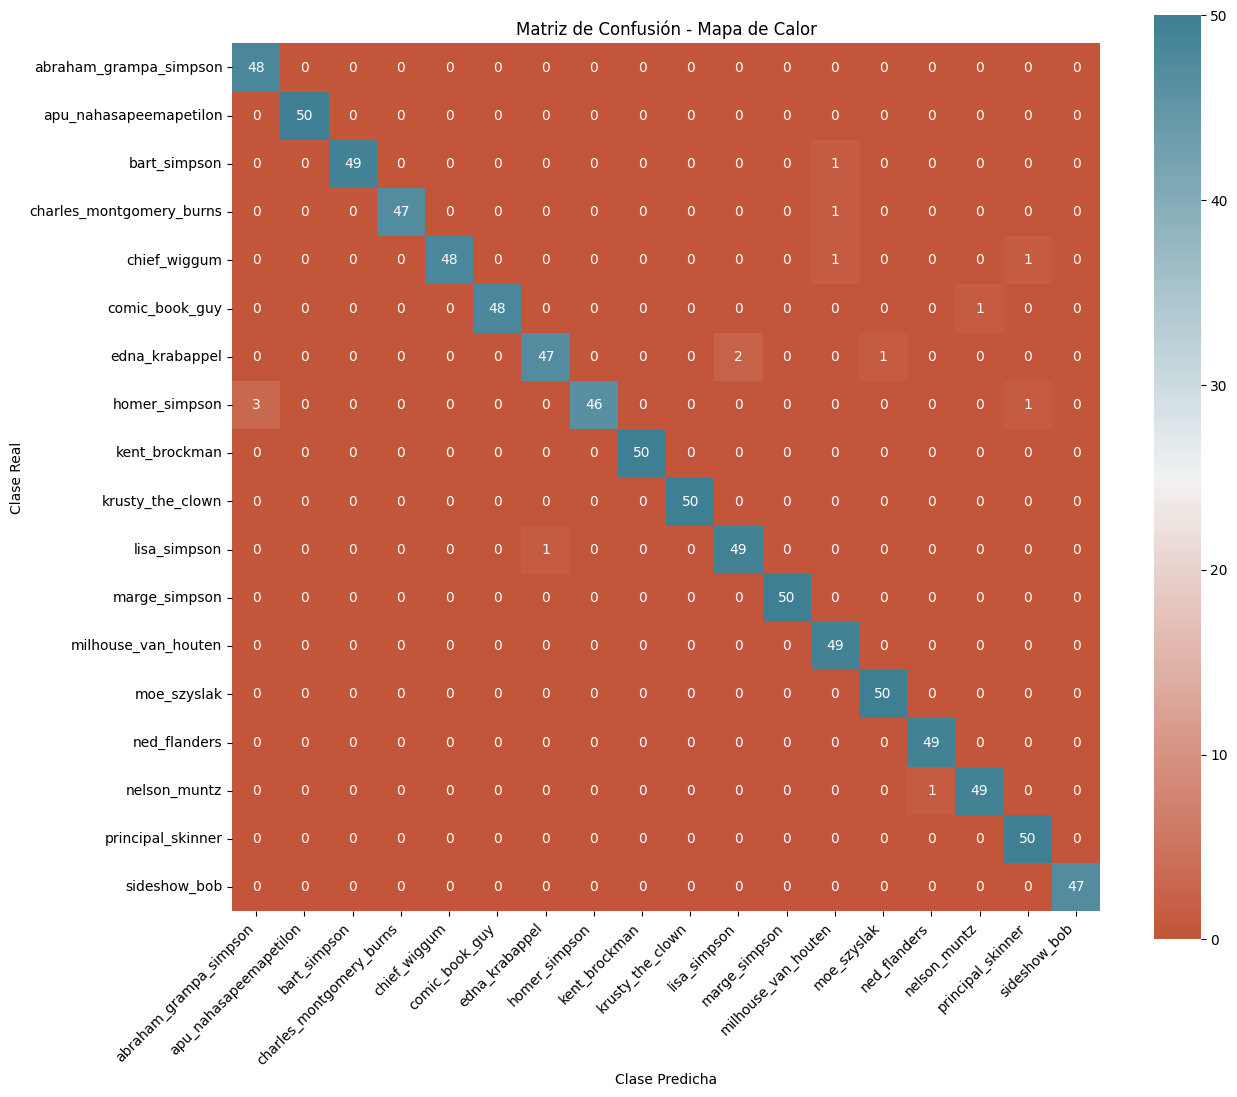

In [33]:
# Generación las variables que faltaban (Y_true y Y_pred_classes) 

# Predecimos con el modelo usando el set de prueba (X_t)
y_pred = model_custom.predict(X_t)

# Convertimos de vectores "One-Hot Encoding" a números enteros (ej: [0,0,1,0] -> 2)
Y_pred_classes = np.argmax(y_pred, axis=1) 
Y_true = np.argmax(y_t, axis=1)            

# Graficar la Matriz de Confusión con estilo Heatmap 

# Definimos los nombres de las clases
target_names = class_names 

# Calculamos la matriz
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Configuración del gráfico
plt.figure(figsize=(14, 12)) 

# Generar el Heatmap
ax = sb.heatmap(
    confusion_mtx, 
    annot=True,                                
    fmt='d',                                    
    cmap=sb.diverging_palette(20, 220, n=200),  
    square=True,
    xticklabels=target_names,
    yticklabels=target_names
)

# Estilizar rotación de etiquetas
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.title('Matriz de Confusión - Mapa de Calor')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.show()

A continuación, veremos algunas imágenes con sus respectivas etiquetas y  precisión de acuerdo a los resultados del modelo. Asi como su gráfico de predicción. Si la barra es azul, acertó. Si es roja, falló (se imprimira en qué personaje se confundió).

Generando predicciones con model_custom...
28/28 [==============================] - 0s 9ms/step


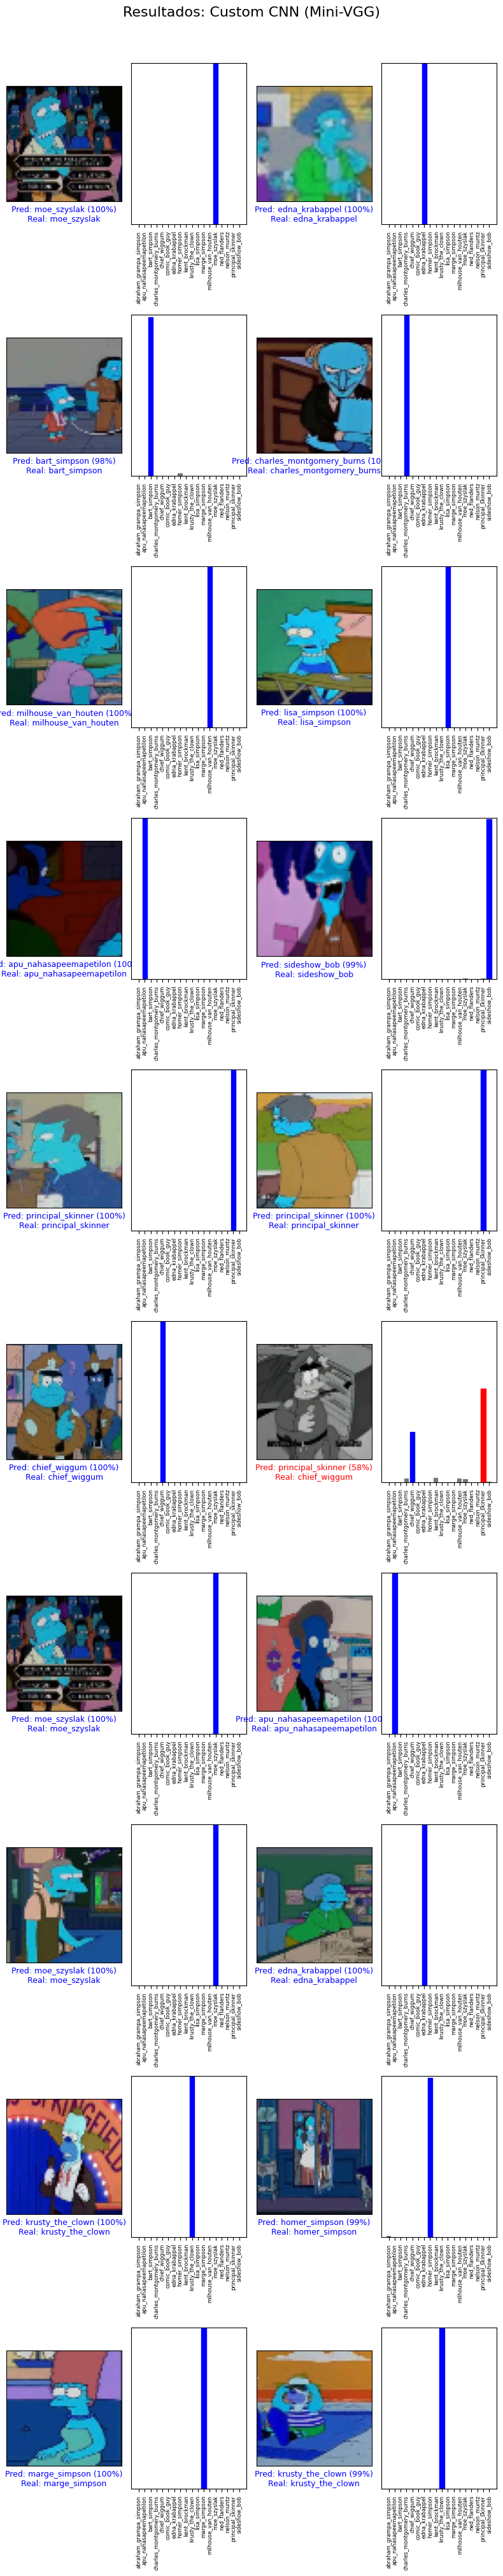

In [39]:
# GENERACIÓN PREDICCIONES CON EL NUEVO MODELO Mini-VGG

print("Generando predicciones con model_custom...")
y_pred = model_custom.predict(X_t)
labels_test = y_t # Aseguramos consistencia

# VISUALIZACIÓN

# Función para dibujar la imagen y etiqueta
def plot_image(i, predictions_array, true_label, img):
    # Ajuste de dimensiones si es One-Hot
    if len(true_label.shape) > 1:
        true_label_indices = np.argmax(true_label, axis=1)
    else:
        true_label_indices = true_label

    predictions_array, true_label, img = predictions_array[i], true_label_indices[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    # Color azul (acierto) o rojo (Fallo)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    label = "Pred: {} ({:2.0f}%)\nReal: {}".format(
        class_names[predicted_label],
        100 * np.max(predictions_array),
        class_names[true_label])
    plt.xlabel(label, color=color, fontsize=9)

# Función para dibujar las barras de probabilidad
def plot_value_array(i, predictions_array, true_label):
    if len(true_label.shape) > 1:
        true_label = np.argmax(true_label, axis=1)
        
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(range(len(class_names)), class_names, rotation=90, fontsize=6)
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Configuración del gráfico
num_rows = 10
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(2 * 2 * num_cols, 4 * num_rows))

for i in range(num_images):
    # Selección aleatoria de imagenes
    idx = np.random.randint(0, len(X_t))
    
    # Columna 1: Imagen
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(idx, y_pred, labels_test, X_t)
    
    # Columna 2: Gráfica de barras
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(idx, y_pred, labels_test)

plt.suptitle("Resultados: Custom CNN (Mini-VGG)", fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

## 3. Conclusión del Desempeño

El resultado final del 98.43% de precisión no es accidental; es el producto de una arquitectura equilibrada. La combinación de BatchNormalization (para velocidad y estabilidad) con un Dropout alto (para generalización) ha permitido entrenar un modelo que, a pesar de tener una capa densa de 512 neuronas, evita completamente el sobreajuste (overfitting), entregando predicciones altamente fiables en el conjunto de prueba.

# Conclusión General del la Actividad #2

El análisis comparativo determina que la CNN Personalizada (Mini-VGG) fue indiscutiblemente la solución óptima, alcanzando una precisión del 98.43%. Su superioridad radica en que fue diseñada específicamente para la topología de los datos de entrada (imágenes de 64x64), logrando extraer características eficientemente sin pérdida de información.

Por el contrario, MobileNetV2 (incluso con fine-tuning) se estancó en un 73.03%. Aunque el aprendizaje por transferencia demostró su utilidad al mejorar el modelo base (del 43% al 70%), el rendimiento final se vio severamente castigado por la incompatibilidad de resolución; una arquitectura diseñada para alta definición (224x224) no puede operar a su máximo potencial con entradas de baja dimensionalidad.

Por lo tanto, para datasets con restricciones severas de resolución, una arquitectura simple y dedicada supera a modelos pre-entrenados complejos ("Estado del Arte"), demostrando que la adecuación al dato prevalece sobre la complejidad del algoritmo.


=== TABLA COMPARATIVA DE MÉTRICAS ===
        Modelo  Accuracy       MCC     Kappa
0   CNN Simple  0.975281  0.973911  0.973827
1  MobileNetV2  0.730337  0.716262  0.714479
2   Custom CNN  0.984270  0.983378  0.983344


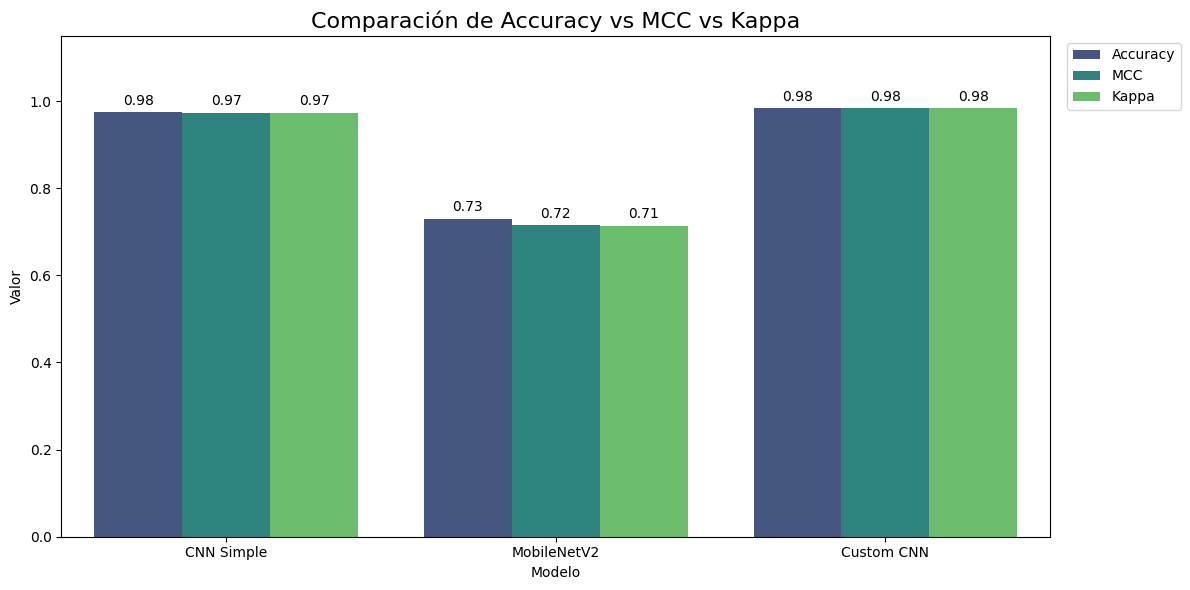

In [37]:
import pandas as pd
# Recopilación los datos para la gráfica comparativa
data = {
    'Modelo': ['CNN Simple', 'MobileNetV2', 'Custom CNN'],
    'Accuracy': [score[1], score_mn[1], score_custom[1]],
    'MCC': [mcc, mcc_mn, mcc_custom],
    'Kappa': [kappa, kappa_mn, kappa_custom]
}

# Creamos la Tabla 
df_metrics = pd.DataFrame(data)

print("\n=== TABLA COMPARATIVA DE MÉTRICAS ===")
print(df_metrics)
print("=====================================")

# Visualización Gráfica & Transformamos los datos para poder graficarlos fácilmente
df_melted = df_metrics.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

plt.figure(figsize=(12, 6))
sns_plot = sb.barplot(x="Modelo", y="Valor", hue="Métrica", data=df_melted, palette="viridis")

for container in sns_plot.containers:
    sns_plot.bar_label(container, fmt='%.2f', padding=3)

plt.title('Comparación de Accuracy vs MCC vs Kappa', fontsize=16)
plt.ylim(0, 1.15)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

Como podemos obervar (Accuracy, MCC, Kappa) están muy parejas (casi a la misma altura), significa que nuestro dataset esta balanceado y el modelo es robusto.

* Si la barra de Accuracy fuese alta pero MCC/Kappa estuvieran bajos, significaría que el modelo está haciendo trampa: prediciendo bien las clases mayoritarias (ej. Homer Simpson) pero fallando en las difíciles, y el Accuracy "esconde" ese error. El MCC nos revela la verdad.

***

# REFERENCIAS BIBLIOGRÁFICAS
***
[1] Simonyan, K., & Zisserman, A. (2015). Very deep convolutional networks for large-scale image recognition. En International Conference on Learning Representations (ICLR). https://arxiv.org/abs/1409.1556

[2] Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). MobileNetV2: Inverted residuals and linear bottlenecks. En Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4510-4520)

[3] Chollet, F. (2021). Deep learning with Python (2.ª ed.). Manning Publications.

[4] Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT Press. http://www.deeplearningbook.org